# Capstone Project - Journal of Emotion

- __Student name: Chamila Dharmawardhana__  
- __Student pace: Full time__  
- __Scheduled project review date: July 28, 2020__  
- __Instructor name: Amber Yandow__

## developing the user model
Objective: 
- continious improvement of the model specific to the user
- prepared a small selection of my own images, about 10/emotion and trained it using the best CNN model in this study
- Evaluate the tuned model 
- demonstrate for specific user with only a small set of images a reasonable estimation of emotion can be obtained
- This model will improve as user imputs more and more images by his/her's own estimation of labels. 

__connect to google drive to work in colab__

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
path='drive/My Drive/Facial-Expression-Detection-V2'
print(os.listdir(path))

['3.jpg', 'face_crop.py', '2.jpg', '.gitignore', 'LICENSE', '1.jpg', 'haarcascade_frontalface_alt.xml', 'README.md', '.ipynb_checkpoints', 'data', 'fer2013', '.git', 'sample_2.jpg', 'sample_6.jpg', 'backup', 'models', 'FED_regularize_final.ipynb', 'junk', 'FED_transfer_final.ipynb', 'photo.jpg', 'capture.jpg', 'FIW_stage2.ipynb', 'user_stage3.ipynb']


In [4]:
# Load essential libraries
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data handling. 

Here ConfigProto will request number of CPU/GPU nodes needed for the calculation and setup tensorflow for parallel calculations

- 77 images were selected after cleaning and croping
- since the dataset is too small overestimation is quick and unavoidable
- even with this small set of images the inferance is pretty good, and will only improve with time


In [5]:
#------------------------------
#cpu - gpu configuration
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 8 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
#sess = tf.Session(config=config) 
#keras.backend.set_session(config)

#------------------------------
# google scraped images included 

with open(path+"/data/user.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []
num_classes = 7                           #angry, disgust, fear, happy, sad, surprise, neutral

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------

number of instances:  77
instance length:  2304
60 train samples
16 test samples


same CNN as the improved model for FER2013 dataset is used here with very minor adjusments. 

In [6]:
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
epochs = 25
batch_size = 256
l2_num = 0.001

#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (5, 5), strides=1, padding='same', input_shape=(48, 48, 1) , kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(2048, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('softmax'))

#------------------------------
#batch process
gen = ImageDataGenerator(zoom_range=0.3)
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
test_generator = gen.flow(x_test, y_test, batch_size=batch_size)


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'] )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
#------------------------------

fit = False

if fit == False:
    #model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
    history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs, 
                                  validation_data=test_generator) #train for randomly selected one
    model.save(path+'/models/model_reg_user.h5')
else:
    model = load_model(path+'/models/model_reg_user.h5') #load weights


Epoch 1/25
256/256 [==============================] - 33s 131ms/step - loss: 1.9222 - accuracy: 0.8919 - val_loss: 3.2203 - val_accuracy: 0.1875
Epoch 2/25
256/256 [==============================] - 26s 100ms/step - loss: 0.8234 - accuracy: 0.9869 - val_loss: 3.5845 - val_accuracy: 0.5000
Epoch 3/25
256/256 [==============================] - 26s 101ms/step - loss: 0.5080 - accuracy: 0.9943 - val_loss: 5.9692 - val_accuracy: 0.3750
Epoch 4/25
256/256 [==============================] - 26s 101ms/step - loss: 0.3091 - accuracy: 0.9947 - val_loss: 5.1747 - val_accuracy: 0.3750
Epoch 5/25
256/256 [==============================] - 26s 101ms/step - loss: 0.5431 - accuracy: 0.9854 - val_loss: 5.0569 - val_accuracy: 0.3125
Epoch 6/25
256/256 [==============================] - 26s 101ms/step - loss: 0.3444 - accuracy: 0.9982 - val_loss: 4.2643 - val_accuracy: 0.3750
Epoch 7/25
256/256 [==============================] - 26s 101ms/step - loss: 0.3182 - accuracy: 0.9894 - val_loss: 9.0094 - val_ac

## **evaluate the  user Model**

In [7]:
#Evaluation
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.19520685076713562
Train accuracy: 100.0
Test loss: 4.1193718910217285
Test accuracy: 50.0


Following funtiction builds a barchart for a given mages emotion analysis

In [8]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

Visual inspection of the results show most picture and predictions looks to be correct. Thus even with the modest accuracy the model does well. 

In [11]:
#Confusion Matrix.

from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(x_test)
pred_list = []; actual_list = []
 
for i in predictions: 
    pred_list.append(np.argmax(i))


for i in y_test: 
    actual_list.append(np.argmax(i))


cm = confusion_matrix(actual_list, pred_list)
cm

array([[0, 1, 1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1],
       [0, 0, 1, 0, 0, 2, 0],
       [1, 0, 0, 0, 0, 0, 1]])

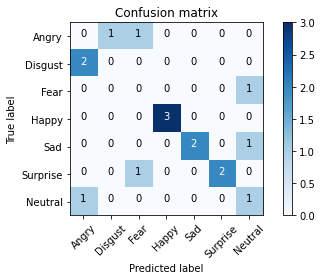

In [12]:
import itertools
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Confusion matrix looks okay considering how small the image sample is. 

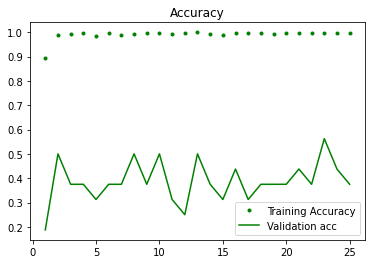

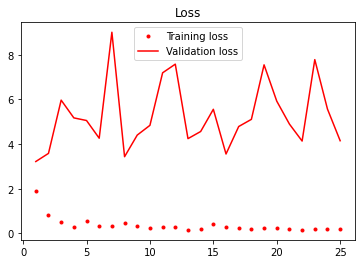

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

It is observed that after about 5 epoch model tend to overfit and can only be improved with more images in the training sample. 

following function can be used to obtain the prediction for any given picture. This function can be usen in the journal app for predictions. 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


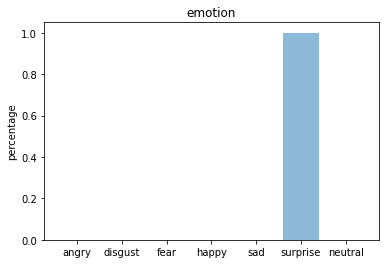

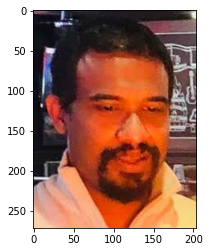

In [14]:
#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

def plotface(file):
    #file = path+'/1.jpg'
    true_image = image.load_img(file)
    img = image.load_img(file, grayscale=True, target_size=(48, 48))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(true_image)
    plt.show()

plotface(path+'/sample_6.jpg')

As shown above the prediction for the given image is not that good. Thus to further improve the predictions we must crop the face from the image so the background is ignored when predicting emotion. Following functino uses the HAAR cascade pre-trained model provided by opneCV to detect and crop a face from an image. 

Writing: drive/My Drive/Facial-Expression-Detection-V2/sample_6.jpg


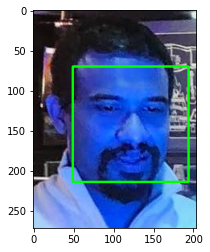

In [15]:
import cv2

def facecrop(image):  
    """
    Use pretrained HAAR cascade to detect the face and build a bounding box 
    """
    facedata = '/content/drive/My Drive/Facial-Expression-Detection-V2/haarcascade_frontalface_alt.xml'
    #facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite(path+'/capture.jpg', sub_face)
            print ("Writing: " + image)

    except Exception as e:
        print (e)

    #cv2.imshow(image, img)
    plt.imshow(img)


facecrop(path+'/sample_6.jpg')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


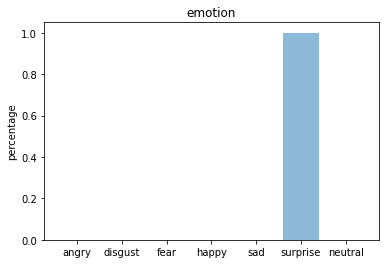

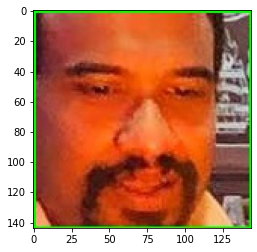

In [16]:
plotface(path+'/capture.jpg')

As we observe the predictions for the croped image is much better. Thus this fuction can be used in the journal app to crop the face from an image before it is fed to the model. 

Following function is taken from google.colab to enable webcan within the colab notebook. This allows to take a picture directly from the webcam, save it to the disk and make predictions by calling facecrop() and plotface() functions. 

In [ ]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=path+'/photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [ ]:
#take_photo()

In [ ]:
#Test the captured image
#facecrop(path+'/photo.jpg')

In [ ]:
#plotface(path+'/capture.jpg')

## conclusion

- user specific model can be trained with fewer images.
- the continued training images are well curated by the user.
- the model will continiously improve with usage.